In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [3]:
#load data
dataName="_visualDurEstimate_2025-03-12_20h35.26.573.csv"

data = pd.read_csv("data/"+dataName)
data

,Unnamed: 0,standardDur,riseDur,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,stair_num_reversal,stair_is_reversal,response_keys,conflictDur,recordedOnsetVisualTest,recordedOffsetVisualTest,recordedDurVisualTest,recordedOnsetVisualStandard,recordedOffsetVisualStandard,recordedDurVisualStandard
0,0,0.5003,0.7504,2,0.5753,0.6504,0.8838,0,2.7853,-0.6500,...,0,False,left,0.05,1.9550,2.1302,0.1752,0.5717,1.0714,0.4997
1,1,0.5003,0.7504,2,0.4419,0.6504,0.8005,1,2.4427,-0.9000,...,0,False,left,-0.05,1.7412,1.7910,0.0499,0.4406,0.9409,0.5004
2,2,0.5003,0.7504,1,0.4919,0.4919,0.6254,2,2.9350,0.6500,...,0,False,left,0.00,0.4855,1.3107,0.8252,1.9355,2.4358,0.5003
3,3,0.5003,0.7504,1,0.6254,0.5003,0.5837,3,2.3852,-0.6500,...,0,False,right,0.05,0.6195,0.7946,0.1751,1.3773,1.8777,0.5004
4,4,0.5003,0.1001,1,0.5420,0.6003,0.6254,4,3.0931,0.6500,...,0,False,right,-0.05,0.5350,1.3600,0.8250,1.9850,2.4851,0.5001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,105,0.5003,0.1001,1,0.6087,0.4419,0.7671,105,2.9188,0.2044,...,3,True,right,0.05,0.6061,1.2061,0.6000,1.9729,2.4730,0.5001
106,106,0.5003,0.7504,1,0.4753,0.4002,0.5086,106,2.2008,-0.3622,...,2,True,right,-0.05,0.4693,0.7861,0.3168,1.2944,1.7946,0.5002
107,107,0.5003,0.7504,2,0.6087,0.5753,0.8088,107,3.1435,0.2942,...,3,False,left,0.00,1.9137,2.5636,0.6499,0.6053,1.1052,0.4999
108,108,0.5003,0.7504,1,0.4919,0.6087,0.6670,108,2.5852,-0.3622,...,2,True,left,0.05,0.4865,0.8035,0.3170,1.4699,1.9703,0.5003


In [4]:
from scipy.stats import norm
from scipy.optimize import minimize

# Define Psychometric Function and Optimization

In [19]:

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

def derivative_psychometric_function(intensities, lapse_rate, mu, sigma):
    #F'(x) = (1-lambda)*(1(/sqrt(2*pi)sigma)exp((x-mu)^2/sigma^2)

    return (1 - lapse_rate) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((intensities - mu) ** 2) / (2 * sigma ** 2))    

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, totalResp):
    lambda_, mu, sigma = params # Unpack parameters
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (totalResp - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):

    # then fits the psychometric function
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


#  Raw psychometric

In [20]:
def rawNegLogLike(params, level, response):
    # Unpack parameters
    lapse_rate, mu, sigma = params
    # Compute the probability of choosing test
    p = psychometric_function(level, lapse_rate, mu, sigma)
    # Add a small number to avoid log(0)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(response * np.log(p) + (1 - response) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fitPsychometricRaw(levels, response,init_guesses=[0,0,0]):
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        rawNegLogLike, x0=init_guesses, 
        args=(levels, response),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x


# Group data

In [7]:
# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    print(data["rise_dur"]>1)
except:
    data["rise_dur"]=1

data['standard_dur']=data['standardDur']

def groupByChooseTest(x):
    grouped = x.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

def groupByStandardDur(x):
    grouped = x.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['pChooseStandard'] = grouped['num_of_chose_standard'] / grouped['total_responses']

    return grouped

grouped=groupByChooseTest(data)
# p_choose_test
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])

# Estimate initial parameters

In [23]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    max_sigma = intensity_range * max_sigma_ratio
    #sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]
estimate_initial_guesses(grouped['delta_dur_percents'],grouped['num_of_chose_test'],grouped['total_responses'])

def estimateInitialGuessesRaw(levels,responses,maxSigmaRatio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    # Compute proportion of "chose test"
    proportions = responses / levels
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(levels, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(levels)) - np.abs(min(levels))
    max_sigma = intensity_range * maxSigmaRatio
    sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]


# 1 by 1 Psychometric Function fitting

In [9]:
conflictLeves=sorted(data['conflictDur'].unique())
standardDurLevels=sorted(data['standardDur'].unique())
noiseLevels=sorted(data['rise_dur'].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.5003], Conflict levels: [-0.05, 0.0, 0.05], Noise levels: [1]


Standard duration: 0.5003, Noise level: 1, Conflict level: -0.05, Fitted parameters: [ 0.2        -0.00291505  0.05      ]
Standard duration: 0.5003, Noise level: 1, Conflict level: 0.0, Fitted parameters: [0.2        0.13311673 0.51183427]
Standard duration: 0.5003, Noise level: 1, Conflict level: 0.05, Fitted parameters: [ 0.2        -0.03622007  0.24464794]


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_60492/1888938989.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


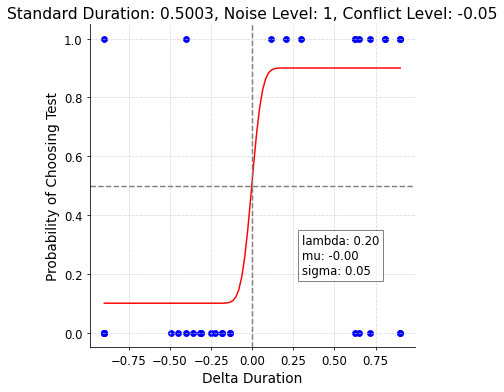

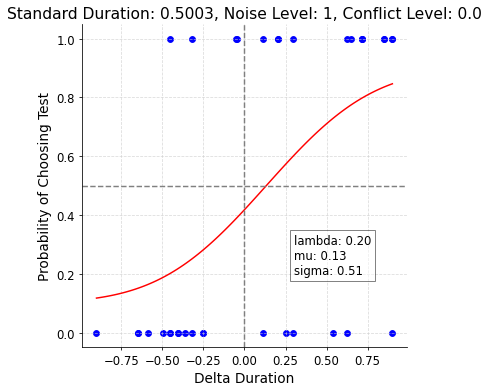

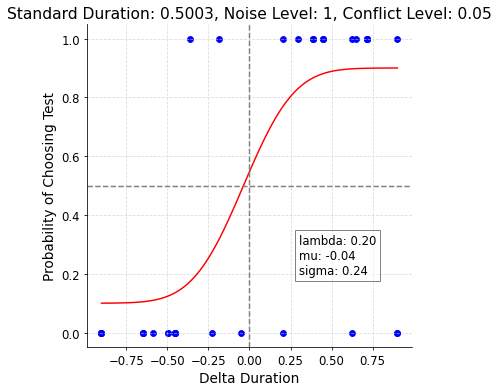

In [15]:
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        for k, conflictLevel in enumerate(conflictLeves):        
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["rise_dur"]==noiseLevel]

            # select levels
            levels=df['delta_dur_percents'].values
            responses=df['chose_test'].values
            # estimate initial guesses
            initial_guesses = estimateInitialGuessesRaw(levels, responses)
               
            # fit psychometric function
            fitted_params = fitPsychometricRaw(levels, responses,initial_guesses)
            # print fitted parameters
            print(f"Standard duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

            # plot psychometric function
            plt.figure()
            plt.scatter(levels, responses, label='Data', color='blue')
            x = np.linspace(-0.9, 0.9, 100)
            y = psychometric_function(x, *fitted_params)
            plt.plot(x, y, label='Psychometric Function', color='red')
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Delta Duration')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Duration: {standardLevel}, Noise Level: {noiseLevel}, Conflict Level: {conflictLevel}')
            # add fitted parameters to the plot
            plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.5))

            # # Binned data
            # binSize=8 # number of bins
            # binEdges = np.linspace(-0.9, 0.9, binSize + 1)
            # binCenters = 0.5 * (binEdges[:-1] + binEdges[1:])
            # binnedResponses = np.zeros(binSize)
            # binnedCounts = np.zeros(binSize)
            # for i in range(binSize):
            #     binMask = (levels >= binEdges[i]) & (levels < binEdges[i + 1])
            #     binnedResponses[i] = np.sum(responses[binMask])
            #     binnedCounts[i] = np.sum(binMask)
            # binnedProportions = binnedResponses / binnedCounts
            # # Plot each binCenter individually with marker size based on the number of responses
            # for binCenter, proportion, count in zip(binCenters, binnedProportions, binnedCounts):
            #     marker_size = (count / totalResponses + 0.5) * 100  # Adjust marker size based on count
            #     plt.scatter(binCenter, proportion, s=marker_size, color='green', label='Binned Data' if binCenter == binCenters[0] else "")
            # plt.legend()



            

# Aggregate data and fit psychometric function

Standard duration: 0.5003, Noise level: 1, Conflict level: -0.05, Fitted parameters: [0.2        0.39999775 0.53038631]
Standard duration: 0.5003, Noise level: 1, Conflict level: 0.0, Fitted parameters: [0.         0.16252743 0.67766497]
Standard duration: 0.5003, Noise level: 1, Conflict level: 0.05, Fitted parameters: [ 0.2        -0.03622166  0.24469098]


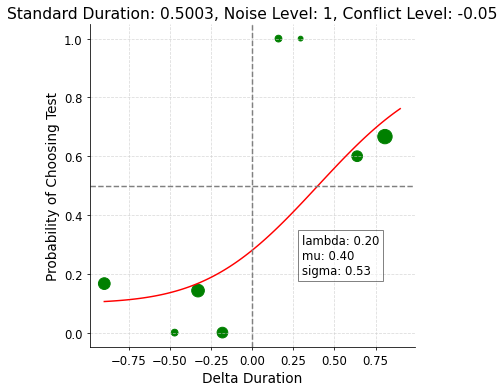

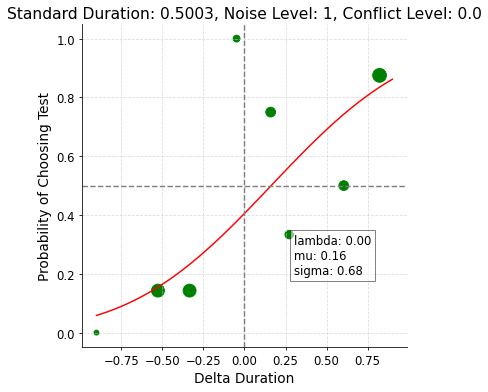

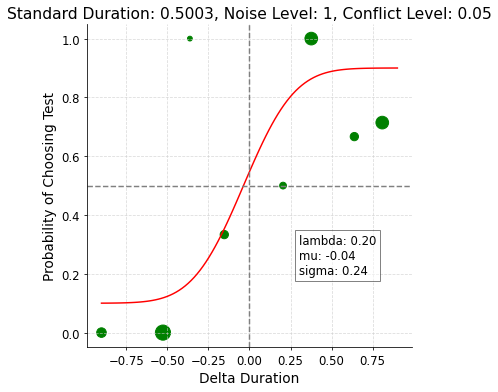

In [40]:
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        for k, conflictLevel in enumerate(conflictLeves):        
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["rise_dur"]==noiseLevel]

            grouped=groupByChooseTest(df)
            # p_choose_test
            levels=grouped['delta_dur_percents'].values
            responses=grouped['num_of_chose_test'].values
            totalResponses=grouped['total_responses'].values
            # estimate initial guesses
            initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
            # fit psychometric function
            fitted_params = fit_psychometric_function(levels, responses, totalResponses,initial_guesses)
            # print fitted parameters
            print(f"Standard duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

            # plot psychometric function
            plt.figure()
            #plt.scatter(levels, responses/totalResponses, label='Data', color='blue')
            x = np.linspace(-0.9, 0.9, 100)
            y = psychometric_function(x, *fitted_params)
            plt.plot(x, y, label='Psychometric Function', color='red')
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Delta Duration')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Duration: {standardLevel}, Noise Level: {noiseLevel}, Conflict Level: {conflictLevel}')
            # add fitted parameters to the plot
            plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.5))
            
            # Bin using pd.cut
            binSize=8 # number of bins
            grouped['bin'] = pd.cut(grouped['delta_dur_percents'], bins=binSize,
                                    labels=False, include_lowest=True,retbins=False)
            #calculate means and sums for each bin
            binGroup=grouped.groupby('bin').agg(
                mean_delta_dur=('delta_dur_percents', 'mean'),
                sum_num_of_chose_test=('num_of_chose_test', 'sum'),
                sum_total_responses=('total_responses', 'sum')
            ).reset_index()
            #total responses for normalization of marker size
            totalResponses=grouped['total_responses'].sum()
            #calculate proportions
            binGroup['pChooseTest'] = binGroup['sum_num_of_chose_test'] / binGroup['sum_total_responses']
            #plot binned data
            plt.scatter(binGroup['mean_delta_dur'], binGroup['pChooseTest'], label='Binned Data', color='green'
                        ,s=binGroup['sum_total_responses']/totalResponses*900)
            


# Wholesome Psychometric Function fitting

Standard  of 0.5003s, Rise of 1s
Initial guesses: 0.030, 0.192, 0.335
Fitted parameters λ: 0.200, μ: 0.182, σ: 0.480


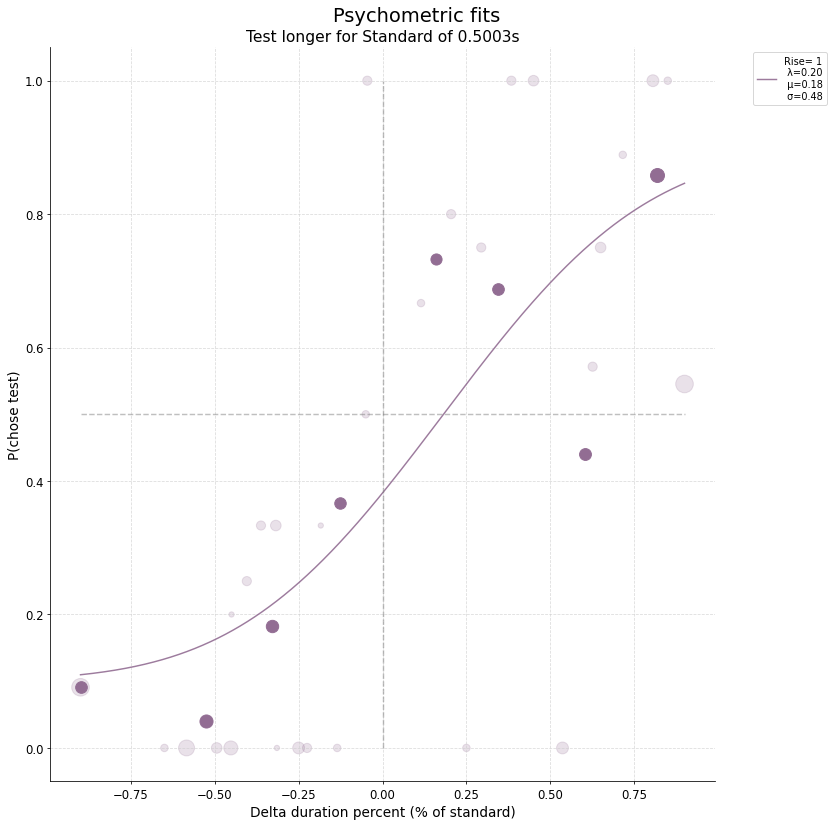

In [ ]:
from random import seed
import random
from scipy.stats import binned_statistic

seed(10)
# Generate a random hex color code
def random_hex_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))
# Control color generation within a specific range (e.g., for pastel colors)
def random_pastel_color():
    return (random.uniform(0.6, 1), random.uniform(0.6, 1), random.uniform(0.6, 1))
# Generate a random RGB tuple (values between 0 and 1)
def random_rgb_color():
    return (random.random(), random.random(), random.random())


def plot_psychometric_functions(data):
    fig, axs = plt.subplots(1,1, figsize=(12, 12))
    fig.suptitle('Psychometric fits', fontsize=20)

    #sort the data by standard duration
    data = data.sort_values(by='standard_dur')
    # fildering loop for each standard duration
    for k, i in enumerate(data['standard_dur'].unique()):
        # Filter data by standard duration
        data_by_standard = data[data['standard_dur'] == i].copy()

        # Group data by delta_dur_percents and rise_dur
        aggregated_data = data_by_standard.groupby(['delta_dur_percents', 'rise_dur']).agg(
                num_of_chose_test=('chose_test', 'sum'),
                total_responses=('responses', 'count'),
        ).reset_index()
        # Calculate the probability of choosing the test
        aggregated_data['p_choose_test'] = aggregated_data['num_of_chose_test'] / aggregated_data['total_responses']
        # sort the values
        aggregated_data = aggregated_data.sort_values(by='rise_dur')
        # select each rise_dur and fit the psychometric function
        for j in aggregated_data['rise_dur'].unique():
            #lineStyle = '--' if j == 0.80 else '-'  # Different line style for rise_dur=0.050
            #lineColor = 'darkgreen' if j == 4.5 else 'orange'  # Different line color for rise_dur=0.050
            lineColor=random_rgb_color()
            # Filter the data by rise_dur
            X = aggregated_data[aggregated_data['rise_dur'] == j]
   
            params_init = estimate_initial_guesses(X)
            # if np.abs(params_init[1])>0.5:
            #     params_init[1]=0

            print(f'Standard  of {i}s, Rise of {j}s')
            print(f"Initial guesses: {params_init[0]:.3f}, {params_init[1]:.3f}, {params_init[2]:.3f}")
            lambda_hat, mu_hat, sigma_hat = fit_psychometric_function(X,init_guesses=params_init) # Fit psychometric function

            print(f"Fitted parameters λ: {lambda_hat:.3f}, μ: {mu_hat:.3f}, σ: {sigma_hat:.3f}")

            x_data = X['delta_dur_percents']
            y_data = X['p_choose_test']
                        
            # # Normalize bin sizes for scatter plot
            #ax = axs[k // 2, k % 2]
            X=X.sort_values(by='delta_dur_percents')
            # bin_size=10
            # bin_distance=0.3
            # x_data=X['delta_dur_percents']
            # y_data=X['p_choose_test']
            total_bins=X['total_responses']

            # for m in np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']),bin_size):
            #         # search for values +- 0.2 of the i value
            #         mask=(x_data>=m-bin_distance) & (x_data<m+bin_distance)
            #         # get the mean of the values
            #         x_mean=np.mean(x_data[mask])
            #         y_mean=np.mean(y_data[mask])
            #         # get the total responses
            #         total_resp=np.sum(total_bins[mask])
            #         # plot the mean values
            #         plt.plot(x_mean,y_mean,'o',markersize=((total_resp/np.sum(total_bins)+0.3)*20),color=lineColor)
            
            #Binning using pd.Cut 
            bin_size = 8  # Number of bins
            # Create bins
            X['bin'] = pd.cut(X['delta_dur_percents'], bins=bin_size, labels=False, retbins=False, include_lowest=True)
            # Calculate means and sums within each bin
            bin_group = X.groupby('bin').agg(
                x_mean=('delta_dur_percents', 'mean'),
                y_mean=('p_choose_test', 'mean'),
                total_resp=('total_responses', 'sum') )
            
            # Total responses for normalization of marker size
            total_responses = X['total_responses'].sum()
            # Plotting
            for index, row in bin_group.iterrows():
                marker_size = (row['total_resp'] / total_responses +0.5) * 20
                plt.plot(row['x_mean'], row['y_mean'],'o',markersize=marker_size,color=lineColor)
            

            # # binning using np.histogram
            # bin_size=6
            # bin_edges = [-0.8 -0.5,-0.3 -0.1, 0, 0.1, 0.3, 0.5, 0.8]

            # hist, bin_edges = np.histogram(X['delta_dur_percents'], bins=bin_edges)    
            # bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            # # Calculate the mean of y_data for each bin
            # y_means = [np.mean(y_data[(x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])]) for i in range(len(bin_edges) - 1)]
            # # Calculate the total responses for each bin
            # total_bins = [np.sum(total_bins[(x_data >= bin_edges[i]) & (x_data < bin_edges[i + 1])]) for i in range(len(bin_edges) - 1)]
            # # Normalize the marker size
            # total_responses = np.sum(total_bins)
            # for i in range(len(bin_centers)):
            #     marker_size = (total_bins[i] / total_responses + 0.5) * 20
            #     plt.plot(bin_centers[i], y_means[i],'o',markersize=marker_size,color=lineColor) 
                           
            # Plot the psychometric function
            x_fit = np.linspace(min(X['delta_dur_percents']),max(X['delta_dur_percents']), 1000)
            y_fit = psychometric_function(x_fit, lambda_hat, mu_hat, sigma_hat)
            plt.plot(x_fit, y_fit, label=f'Rise= {j}\n λ={lambda_hat:.2f}\n μ={mu_hat:.2f}\n σ={sigma_hat:.2f}', alpha=0.9,color=lineColor)
                     #linestyle=lineStyle, color=lineColor,)
            # scatter raw data
            plt.scatter(x_data, y_data, s=X['total_responses']*30, color=lineColor, alpha=0.2)
            plt.vlines(x=0, ymin=0, ymax=1, linestyles='dashed', colors='gray',alpha=0.5)   
            plt.hlines(y=0.5, xmin=min(X['delta_dur_percents']), xmax=max(X['delta_dur_percents']), linestyles='dashed', colors='gray',alpha=0.5)
            plt.xlabel('Delta duration percent (% of standard)')
            plt.ylabel('P(chose test)')
            plt.title(f'Test longer for Standard of {i}s')
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            
    plt.tight_layout()
    plt.show()

# Call the function
plot_psychometric_functions(data)
# Psychometric function fits when the data is pooled across all standard durations 